In [158]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA
import glob
import string

# Load files

In [159]:
files_dict={}

for fl in glob.glob("../20160223_BamData/NoA/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]
NoA=pd.DataFrame(files_dict)
     
files_dict={}
for fl in glob.glob("../20160223_BamData/AdRp/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]   
AdRp=pd.DataFrame(files_dict)

Check that columns are in same order (ie. Zi257C4 in AdRp corresponds to Zi257C4 in NoA).  True

In [160]:
#Remove NoA and AdRp label from columns
AdRp.columns=[ele[:-5] for ele in AdRp.columns]
NoA.columns=[ele[:-4] for ele in NoA.columns]

sum(AdRp.columns.values == NoA.columns.values) == len(AdRp.columns)


True

Check that all rows are the same, so the same gene locations are explored in all datasets.  True.

In [168]:
Locations = [pd.read_csv(fl, sep="\t", header=None, usecols=range(3)) for fl in glob.glob("../20160223_BamData/NoA/*")]
print all([df1.equals(df2) for df1 in Locations for df2 in Locations])
Locations=Locations[0]

True


We print the various locations that were sequenced (not base pair numbers).  We notice there is mitochondrion dna: 'mitochondrion_genome'.  We will want to remove that.

In [169]:
Locations[0].unique()

array(['211000022278049', '211000022278185', '211000022278217',
       '211000022278269', '211000022278273', '211000022278279',
       '211000022278354', '211000022278390', '211000022278399',
       '211000022278415', '211000022278498', '211000022278549',
       '211000022278653', '211000022278686', '211000022278777',
       '211000022278849', '211000022278875', '211000022278916',
       '211000022278974', '211000022278978', '211000022279001',
       '211000022279008', '211000022279009', '211000022279022',
       '211000022279094', '211000022279098', '211000022279114',
       '211000022279146', '211000022279189', '211000022279276',
       '211000022279345', '211000022279420', '211000022279423',
       '211000022279446', '211000022279456', '211000022279503',
       '211000022279523', '211000022279556', '211000022279579',
       '211000022279594', '211000022279637', '211000022279676',
       '211000022279681', '211000022279719', '211000022279754',
       '211000022279762', '2110000222798

We remove mitochondrial information in NoA and AdRp, and create new dataframes NoA_noMtDNA and AdRp_noMtDNA.  There are 27 rows that have mitochondrial dna information.  

In [170]:
sum(Locations[0]=='mitochondrion_genome')

27

In [171]:
print NoA.shape, "NoA df shape, before mitochondrion genome entries removed"
NoA_noMtDNA= NoA[Locations[0]!='mitochondrion_genome']
print NoA_noMtDNA.shape, "NoA_noMtDNA shape, after mitochondrion genome removed (27 less values)"

print AdRp.shape, "AdRp df shape, before mitochondrion genome entries removed"
AdRp_noMtDNA= AdRp[Locations[0]!='mitochondrion_genome']
print AdRp_noMtDNA.shape, "AdRp_noMtDNA shape, after mitochondrion genome removed (27 less values)"

(388634, 108) NoA df shape, before mitochondrion genome entries removed
(388607, 108) NoA_noMtDNA shape, after mitochondrion genome removed (27 less values)
(388634, 108) AdRp df shape, before mitochondrion genome entries removed
(388607, 108) AdRp_noMtDNA shape, after mitochondrion genome removed (27 less values)


In [172]:
all(AdRp_noMtDNA.index == NoA_noMtDNA.index)
#AdRp_noMtDNA.index=range(388607)
#NoA_noMtDNA.index=range(388607)

True

Remove mitochondrion genome from Locations dataframe.  Write dataframe to file entitled "Locations"

In [173]:
print Locations.shape
Locations_noMtDNA = Locations[Locations[0]!='mitochondrion_genome']
Locations_noMtDNA.to_csv("Locations")
print Locations_noMtDNA.shape

(388634, 3)
(388607, 3)


We can see that the mitochondrial DNA counts were much much larger.

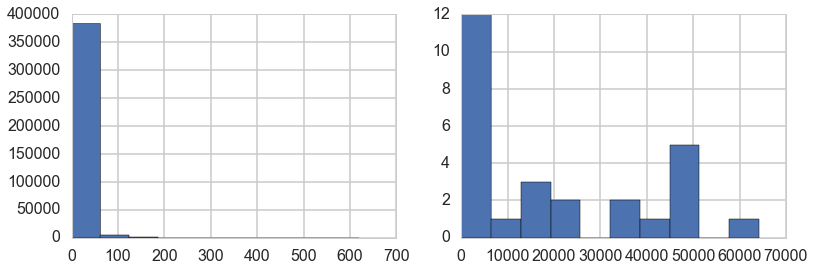

In [174]:
fig = plt.figure()
fig.add_subplot(221)
_=plt.hist(AdRp_noMtDNA["damID-Dam_Fr188_C1"], bins=10)
fig.add_subplot(222)
_=plt.hist(AdRp[Locations[0]=="mitochondrion_genome"]["damID-Dam_Fr188_C1"].values, bins=10)


# Correlate dataframes

Here we correlate the dataframes.  They aren't very correlated.  

[As a first pass, we hadn't removed mitochondrial DNA information, so the datasets looked much more correlated]

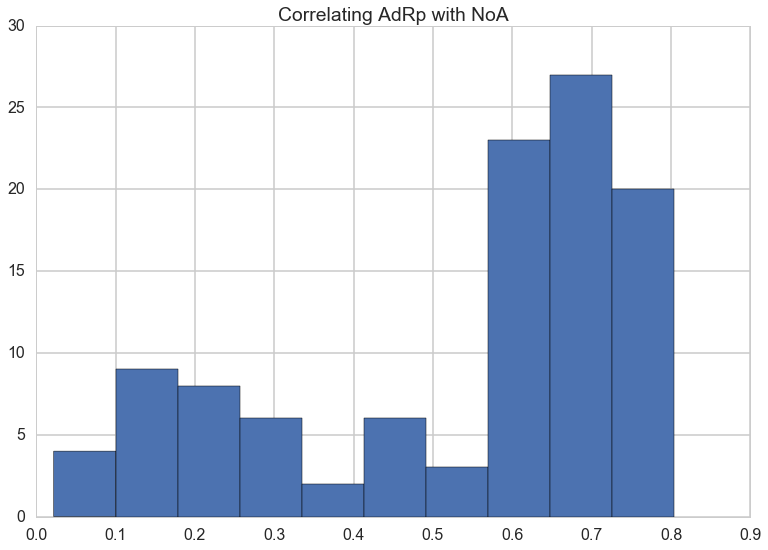

In [175]:
AdRp_NoA_correls = AdRp_noMtDNA.corrwith(NoA_noMtDNA)
_=plt.hist(AdRp_NoA_correls)
_=plt.title("Correlating AdRp with NoA")


# Add values in dataframes that are correlated by more than 70%

Unfortunately, we're down to only 23 columns...

In [176]:
# Take only entries where correlation greater than .70
New_NoA= NoA_noMtDNA[AdRp_NoA_correls[AdRp_NoA_correls>.70].index]
New_AdRp= AdRp_noMtDNA[AdRp_NoA_correls[AdRp_NoA_correls>.70].index]

In [192]:
print New_NoA.shape
New_NoA.shape ==New_AdRp.shape

(388607, 23)


True

Merge NoA and AdRp datasets

In [178]:
Merged = New_NoA.add(New_AdRp)
Merged.to_csv("Merged")
Merged.head()

,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Zi257_C3,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-Dam_Fr188_T2,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1
0,2,3,0,0,1,0,1,2,1,1,1,0,2,0,1,0,0,0,0,0,1,2,1
1,1,3,0,0,1,0,1,1,0,1,1,0,2,0,1,0,0,0,0,0,1,1,0
2,1,3,0,0,1,0,2,1,0,1,1,0,2,0,1,0,0,0,0,0,1,2,0
3,1,4,1,1,3,1,2,2,0,2,1,2,2,0,0,0,0,2,2,1,1,3,2
4,3,4,2,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,2,0


# Keep only columns with combined counts greater than 500000

Actually there was nothing to do here because the minimum column counts was 2703509.

In [179]:
min(Merged.sum(axis=0))

2703509

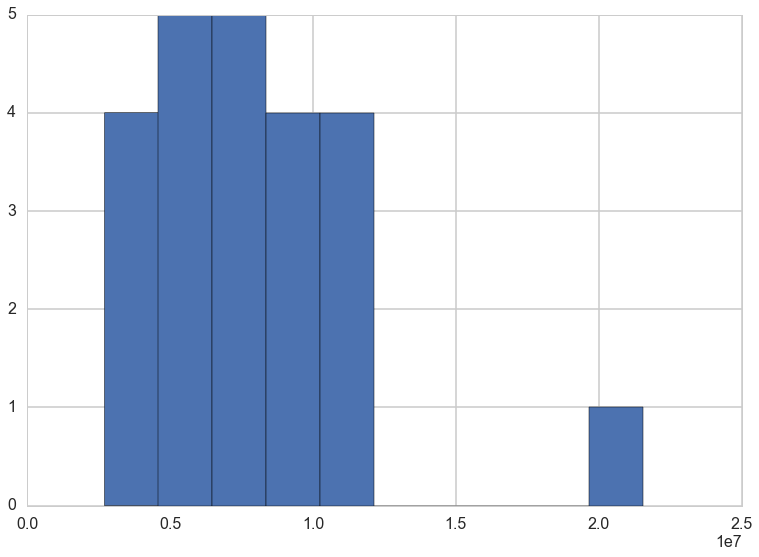

In [180]:
_=plt.hist(Merged.sum(axis=0))

# Making PCAs of each protein/tissue combination

First let's turn column names into a dataframe, so that we can easily separate out tissue, protein, country, line, etc

In [181]:
def split_names(row):
    labels=["RunProtein", "CountryLine", "TissueRep", "dataset", "notSure1", "notSure2"]
    d = {lab:ele for lab,ele in zip(labels, row.split("_"))}
    return d

def split_TissueRep(TissueRep):
    return {label:ele for label, ele in zip(["Tissue", "Rep"], TissueRep)}

def split_CountryLine(CL): 
    return {label:ele for label, ele in zip(["Country", "Line"], [CL[:2], CL[2:]])}

def separate_protein(RunProtein):
    return {label:ele for label, ele in zip(["NotSureProtein", "protein"], RunProtein.split("-"))}

file_names = Merged.columns

ind = [row.split("_cut")[0] for row in file_names]

file_names=pd.DataFrame([split_names(row) for row in file_names])

file_names=pd.concat([file_names, pd.DataFrame([split_TissueRep(row) for row in file_names["TissueRep"]])], axis=1)
del file_names["TissueRep"]

file_names=pd.concat([file_names, pd.DataFrame([split_CountryLine(row) for row in file_names["CountryLine"]])], axis=1)
del file_names["CountryLine"]

file_names=pd.concat([file_names, pd.DataFrame([separate_protein(row) for row in file_names["RunProtein"]])], axis=1)
del file_names["RunProtein"]

file_names.index=ind

file_names

,Rep,Tissue,Country,Line,NotSureProtein,protein
damID-Lam_Fr188_C,NaN,C,Fr,188,damID,Lam
damID-Lam_Fr188_T2,2,T,Fr,188,damID,Lam
damID-Lam_Zi257_C3,3,C,Zi,257,damID,Lam
damID3-D1_Fr188_T,NaN,T,Fr,188,damID3,D1
damID3-D1_Fr188_w1,1,w,Fr,188,damID3,D1
damID3-D1_Fr188_w2,2,w,Fr,188,damID3,D1
damID3-D1_Fr89_w1,1,w,Fr,89,damID3,D1
damID3-D1_Fr89_w2,2,w,Fr,89,damID3,D1
damID3-D1_Zi238_T,NaN,T,Zi,238,damID3,D1
damID3-D1_Zi238_w1,1,w,Zi,238,damID3,D1


In [182]:
file_names.to_csv("file_names")

Next, let's make protein/tissue masks

In [183]:
#Protein masks
DamMask = [file_names.loc[name].protein=="Dam" for name in Merged.columns]
LamMask = [file_names.loc[name].protein=="Lam" for name in Merged.columns]
D1Mask = [file_names.loc[name].protein=="D1" for name in Merged.columns]

#Tissue masks
TMask = [file_names.loc[name].Tissue=="T" for name in Merged.columns]
CMask = [file_names.loc[name].Tissue=="C" for name in Merged.columns]
WMask = [(file_names.loc[name].Tissue=="W" or file_names.loc[name].Tissue=="w") for name in Merged.columns]


In [184]:
DamTMask = [a and b for a, b in zip(DamMask, TMask)]
DamCMask = [a and b for a, b in zip(DamMask, CMask)]
DamWMask = [a and b for a, b in zip(DamMask, WMask)]

LamTMask = [a and b for a, b in zip(LamMask, TMask)]
LamCMask = [a and b for a, b in zip(LamMask, CMask)]
LamWMask = [a and b for a, b in zip(LamMask, WMask)]

D1TMask = [a and b for a, b in zip(D1Mask, TMask)]
D1CMask = [a and b for a, b in zip(D1Mask, CMask)]
D1WMask = [a and b for a, b in zip(D1Mask, WMask)]

Let's normalize the Merged dataset by column counts

In [185]:
MergedNormalized=Merged.div(Merged.sum(axis=0), axis=1)
MergedNormalized.head()

,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Zi257_C3,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-Dam_Fr188_T2,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1
0,1.911296e-07,2.707044e-07,0.000000e+00,0.000000e+00,2.074980e-07,0.000000e+00,1.317960e-07,4.745490e-07,3.542948e-07,1.196173e-07,3.698897e-07,0.000000e+00,1.925403e-07,0,1.447931e-07,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,1.050302e-07,2.118684e-07,1.104141e-07
1,9.556479e-08,2.707044e-07,0.000000e+00,0.000000e+00,2.074980e-07,0.000000e+00,1.317960e-07,2.372745e-07,0.000000e+00,1.196173e-07,3.698897e-07,0.000000e+00,1.925403e-07,0,1.447931e-07,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,1.050302e-07,1.059342e-07,0.000000e+00
2,9.556479e-08,2.707044e-07,0.000000e+00,0.000000e+00,2.074980e-07,0.000000e+00,2.635920e-07,2.372745e-07,0.000000e+00,1.196173e-07,3.698897e-07,0.000000e+00,1.925403e-07,0,1.447931e-07,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,1.050302e-07,2.118684e-07,0.000000e+00
3,9.556479e-08,3.609392e-07,4.638157e-08,1.324061e-07,6.224941e-07,1.744665e-07,2.635920e-07,4.745490e-07,0.000000e+00,2.392346e-07,3.698897e-07,5.295522e-07,1.925403e-07,0,0.000000e+00,0.000000e+00,0,1.808979e-07,2.419740e-07,1.039315e-07,1.050302e-07,3.178025e-07,2.208282e-07
4,2.866944e-07,3.609392e-07,9.276313e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.542948e-07,0.000000e+00,0.000000e+00,2.647761e-07,9.627016e-08,0,0.000000e+00,2.148937e-07,0,0.000000e+00,0.000000e+00,0.000000e+00,1.050302e-07,2.118684e-07,0.000000e+00


In [186]:
#here you can choose to input the normalized or not normalized merged dataset

def create_subdfs(Merged):

    LamT=Merged.ix[:,LamTMask]
    DamT=Merged.ix[:,DamTMask]
    D1T=Merged.ix[:,D1TMask]

    LamC=Merged.ix[:,LamCMask]
    DamC=Merged.ix[:,DamCMask]
    D1C=Merged.ix[:,D1CMask]

    LamW=Merged.ix[:,LamWMask]
    DamW=Merged.ix[:,DamWMask]
    D1W=Merged.ix[:,D1WMask]
    
    return LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W

LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W = create_subdfs(MergedNormalized)

Now we run PCA for each tissue/protein combo.

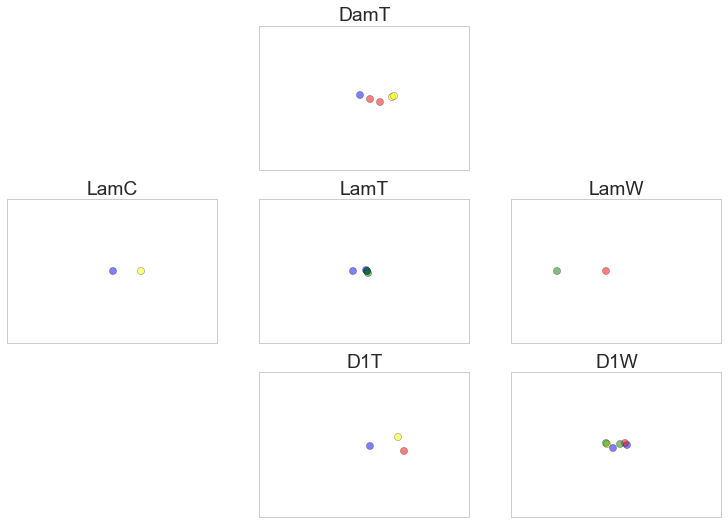

In [187]:
def plot_PCA(data, subplot_spec, title):
    
    pca = PCA(n_components=10)
    X = pca.fit_transform(data.transpose())
    #print pca.explained_variance_ratio_.sum(), "percentage var explained"
    #print pca.explained_variance_ratio_*100, "explained by first PCs"
    
    df=pd.DataFrame()
    for i in range(pca.explained_variance_ratio_.shape[0]):
        df["pc%i" % (i+1)] = X[:,i]

    colors = ["blue", "red", "yellow", 'green']
    labels= ["188","238","257", "89"]
    
    ax1 = fig.add_subplot(subplot_spec, xticklabels=[], yticklabels=[])
    
    for label, color in zip(labels, colors):
        mask = [file_names.loc[name].Line==label for name in data.columns]
        _=ax1.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label, alpha=.5, s =50)
    ax1.set_title(title)
    ax1.grid(b=False)
    #ax1.axis("off")
    #plt.legend()
    #plt.grid(False)
    #plt.show()

fig = plt.figure()

#plot_PCA(DamC, 331, "DamC")
plot_PCA(DamT, 332, "DamT")
#plot_PCA(DamW, 333, "DamW")
plot_PCA(LamC, 334, "LamC")
plot_PCA(LamT, 335, "LamT")
plot_PCA(LamW, 336, "LamW")
#plot_PCA(D1C, 337, "D1C")
plot_PCA(D1T, 338, "D1T")
plot_PCA(D1W, 339, "D1W")



Blue and green are Fr strains, yellow and red are Zi strains

# Normalizing each data set value by mean(Dam-only) value

The final step would be to take mean(D1) / mean(Dam-only) and mean(Lam) / mean(Dam-only) for each line/tissue combination and look at how those values cluster. This should be a very crude way to account for background noise. Note that you'll need to normalize by counts first before averaging across replicates.

In [188]:
CMean=DamC.mean(axis=1)
TMean=DamT.mean(axis=1)
WMean=DamW.mean(axis=1)

In [189]:
LamCNorm = LamC.div(CMean, axis='index')
LamTNorm = LamT.div(TMean, axis='index')
LamWNorm = LamW.div(WMean, axis='index')

D1CNorm = D1C.div(CMean, axis='index')
D1TNorm = D1T.div(TMean, axis='index')
D1WNorm = D1W.div(WMean, axis='index')

DamCNorm = DamC.div(CMean, axis='index')

Drop any rows where there are inf values

In [190]:
LamCNorm=LamCNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamTNorm=LamTNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamWNorm=LamWNorm.replace([np.inf, -np.inf], np.nan).dropna()

D1CNorm=D1CNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1TNorm=D1TNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1WNorm=D1WNorm.replace([np.inf, -np.inf], np.nan).dropna()

DamCNorm=DamCNorm.replace([np.inf, -np.inf], np.nan).dropna()

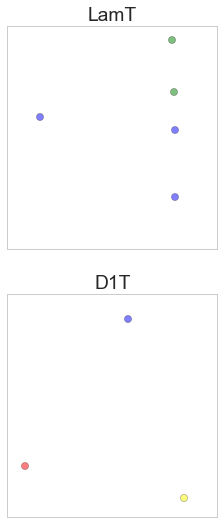

In [191]:
fig = plt.figure()

#plot_PCA(LamCNorm, 231, "LamC")
plot_PCA(LamTNorm, 232, "LamT")
#plot_PCA(LamWNorm, 233, "LamW")
#plot_PCA(D1CNorm, 234, "D1C")
plot_PCA(D1TNorm, 235, "D1T")
#plot_PCA(D1WNorm, 236, "D1W")

# Ignore

First we need to get averages for each line/tissue combo in the Dam dataset

In [141]:
Mask188C = [file_names.loc[name].Line=="188" for name in DamC.columns]
Mask238C = [file_names.loc[name].Line=="238" for name in DamC.columns]
Mask257C = [file_names.loc[name].Line=="257" for name in DamC.columns]
Mask89C = [file_names.loc[name].Line=="89" for name in DamC.columns]

Mask188T = [file_names.loc[name].Line=="188" for name in DamT.columns]
Mask238T = [file_names.loc[name].Line=="238" for name in DamT.columns]
Mask257T = [file_names.loc[name].Line=="257" for name in DamT.columns]
Mask89T = [file_names.loc[name].Line=="89" for name in DamT.columns]

Mask188W = [file_names.loc[name].Line=="188" for name in DamW.columns]
Mask238W = [file_names.loc[name].Line=="238" for name in DamW.columns]
Mask257W = [file_names.loc[name].Line=="257" for name in DamW.columns]
Mask89W = [file_names.loc[name].Line=="89" for name in DamW.columns]

In [147]:
C188=DamC.iloc[:,Mask188C].mean(axis=1)
C89=DamC.iloc[:,Mask89C].mean(axis=1)
C238=DamC.iloc[:,Mask238C].mean(axis=1)
C257=DamC.iloc[:,Mask257C].mean(axis=1)

T188=DamT.iloc[:,Mask188T].mean(axis=1)
T89=DamT.iloc[:,Mask89T].mean(axis=1)
T238=DamT.iloc[:,Mask238T].mean(axis=1)
T257=DamT.iloc[:,Mask257T].mean(axis=1)

T188=DamW.iloc[:,Mask188W].mean(axis=1)
T89=DamW.iloc[:,Mask89W].mean(axis=1)
T238=DamW.iloc[:,Mask238W].mean(axis=1)
T257=DamW.iloc[:,Mask257W].mean(axis=1)